In [89]:
%reset

In [90]:
# Importacionnes
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [91]:
def plot_energy_avg(errores_av, L, l, eta):
    legendas = ["traing", "test"]
    for i in range(len(errores_av)):
        plt.plot(errores_av[i],label=legendas[i])
        plt.title("$\mathcal{E}_{av} - $" + "Hidden Layers: "+ str(L) + "- Neurons: " + str(l) + "- LR: " + str(eta))
        plt.legend()
        plt.savefig('energy capas {} neuronas {} LR {}.png'.format(L,l,eta))
    plt.close()

def average_gradients(deltas_epochs,numero_epocs, L, l, eta):
    promedios = np.zeros((len(deltas_epochs[0]),numero_epocs))
    for i in range(len(deltas_epochs)):
        for j in range(len(deltas_epochs[0])):
            promedios[j,i] = np.mean(np.mean(deltas_epochs[i][j],axis=1))

    legendas = ["$\delta_{input}$"] + ["$\delta_{hidden}$" + str(i+1) for i in range(len(deltas_epochs[0])-2)] + ["$\delta_{output}$"]
    for i in range(len(promedios)):
        plt.plot(promedios[i],label=legendas[i])
        plt.title("$\delta_{av} - $" + "Hidden Layers: "+ str(L) + "- Neurons: " + str(l) + "- LR: " + str(eta))
        plt.legend()
        plt.savefig('gradientes capas {} neuronas {} LR {}.png'.format(L,l,eta))
    plt.close()

def partitioning(datos,size_S,size_T):
    """ 
        Método que hace el partitioning de los datos en el set de S, training, testing y validation
        Recibe:
            1. datos: Datos al cual se le va a hacer el partitioning
            2. Size_S: Tamaño del set S
            3. Size_T: Tamaño del set T (training)
        Entrega:
            1. S: Set S
            2. V: set de validación V
            3. T: set de training T
            4. t: set de testing t
    """
    indices_datos = np.arange(len(datos))

    indices_S = np.random.choice(indices_datos, size=int(round(len(datos)*size_S)),replace=False)
    indices_V = np.setdiff1d(indices_datos, indices_S)
    indices_T = np.random.choice(indices_S, size=int(round(len(datos)*size_T)),replace=False)
    indices_t = np.setdiff1d(indices_S, indices_T)

    S= datos[indices_S]
    
    V= datos[np.random.choice(indices_V, size=len(indices_V),replace=False)]
    T= datos[indices_T]
    t= datos[np.random.choice(indices_t, size=len(indices_t),replace=False)]

    return S,V,T,t

def normalize_min_max(matrix):
    """
        Método para normalizar los datos
        Recibe: 
            1. matrix: Matriz de datos original
        Entrega: 
            1. Matriz de datos normalizados
    """
    max_values = np.max(matrix, axis=0)
    min_values = np.min(matrix, axis=0)

    # Lleva los datos al hiperplano (0, 1) utilizando la normalización min-max
    normalized_data = (matrix - min_values) / (max_values - min_values)
    return normalized_data

def plot_gradiente(deltas,neuronas_por_capa):
    """
        Método que grafica los gradientes
        Recibe: 
            1. deltas: Los deltas de todas las neuronas de todas las capas en cada epoc
            2. neuronas_por_capa: Numero de neuronas por capa
        Entrega: 
            1. Lista de todos los gradientes por capa
    """
    lista1 = []
    for i in range(len(deltas[0])):
        l2 = []
        for j in range(len(deltas)):
            l2.append(deltas[j][i])
        lista1.append(l2)

    l3 = []
    for i in lista1:
        l3.append(np.concatenate(i, axis=1))

    _, axes = plt.subplots(nrows=1, ncols=np.sum(neuronas_por_capa), figsize=(25, 4))

    cont= 0
    for i in range(len(l3)):
        for j in range(len(l3[i])):
            axes[cont].plot(l3[i][j])
            axes[cont].set_title('$\delta$ Capa {} Neurona {}'.format(i+1,j+1))
            axes[cont].set_xlabel("Datos")
            axes[cont].set_ylabel("gradiente")
            cont+=1

    return l3

def plotAverageDeltas(l3):
    """
        Método que grafica el promedio de los gradientes por capa
        Recibe:
            1. l3: Lista de todos los gradientes por capa
    """
    promedios_deltas = []
    for i in l3:
        promedios_deltas.append(np.mean(i, axis=0))
    _, axes = plt.subplots(nrows=1, ncols=len(l3), figsize=(25, 4))

    for i in range(len(promedios_deltas)):
        axes[i].plot(promedios_deltas[i])
        axes[i].set_title('Promedios $\delta$ Capa {}'.format(i+1))
        axes[i].set_xlabel("Datos")
        axes[i].set_ylabel("gradiente")

class MultilayerPerceptron:
    """
        Clase del multilayer perceptron
    """
    def __init__(self,n_neuronas,funciones_activacion):
        """
            Se inicializan todas las variables del objeto
            Recibe:
                1. n_neuronas: lista de numero de neuronas por capa
                2. funciones_activacion: funcion de activacion por capa
        """
        self.n=n_neuronas[0]
        self.n_capas = len(n_neuronas)
        self.n_neuronas = n_neuronas
        self.funciones_activacion = funciones_activacion
        self.nueva_lista = np.insert(self.n_neuronas, 0, self.n)
        self.pesos = [
            np.column_stack((np.random.rand(self.nueva_lista[i+1],self.nueva_lista[i]),np.ones(self.nueva_lista[i+1]))) for i in range(self.n_capas)
        ]

    def activationFunction(self,funcion,v,a=1,b=0):
        """
            Método que retorna la funcion de activacion de un campo
            Recibe:
                1. funcion: que funcion de activacion se va a aplicar
                2. v: campo
            Retorna:
                1: la funcion de activacion aplicada al campo
        """
        if funcion=="tanh": return np.tanh(0.85*v)
        elif funcion=="sigmoid": return 1/(1+np.exp(-(0.4*v)))
        else: return 1.6*v+b

    def derivativeActivationFunction(self,funcion,v,a=1,b=0):
        """
            Método que retorna la derivada de la funcion de activacion de un campo
            Recibe:
                1. funcion: que funcion de activacion se va a aplicar
                2. v: campo
            Retorna:
                1: la derivada de la funcion de activacion aplicada al campo
        """
        if funcion=="tanh": return 0.85*(1-np.tanh(0.85*v)**2)
        elif funcion=="sigmoid": return 0.8*(np.exp(-0.8*v)/((1+np.exp(-0.8*v))**2))
        else: return 1.2*np.ones(v.shape)

    def forward(self, entrada,pesos=None):
        """
            Método que realiza el forrward del perceptron
            Recibe:
                1. entradas: el punto con el que se va a realizar el forward
                2. pesos=None: los pesos con los que se va a realizar el forward
            Entrega:
                1. arreglo de salidas de la ultima capa
                2. funcion de activacion aplicado a cada campo
                3. derivada de la funcion de activacion aplicada a cada campo
        """
        phis = [entrada]
        phis_derivada = []

        if not pesos:
            pesos= self.pesos

        vi = np.dot(pesos[0],np.row_stack((entrada,[1])))
        resultados = self.activationFunction(self.funciones_activacion[0],vi)
        phi_primei = self.derivativeActivationFunction(self.funciones_activacion[0],vi)

        phis.append(resultados)
        phis_derivada.append(phi_primei)

        for i in range(1,self.n_capas):
            vj = np.dot(pesos[i],np.row_stack((resultados,[1])))
            resultados = self.activationFunction(self.funciones_activacion[i],vj)
            phi_prime = self.derivativeActivationFunction(self.funciones_activacion[i],vj)
            phis.append(resultados)
            phis_derivada.append(phi_prime)
        return [i[0] for i in resultados], phis, phis_derivada

    def backpropagation(self,yd, entrada, learning_rate):
        """
            Método que realizar el backpropagation del perceptron
            Recibe:
                1. yd: salida de la capa ocultta del punto
                2. entrada: el punto con el que se va a hacer el backpropagation
                3. learning_rate: el eta (tasa de aprendizaje)
            Entrega:
                1. la matriz de pesos actualizada
                2. deltas de cada neurona por capa
        """
        entrada= np.array([[entrada[i]] for i in range(self.n)])
        out, phis, phis_prime = self.forward(entrada)

        assert len(yd) == len(out)

        deltas = [np.zeros(i) for i in self.n_neuronas]
        delta_k = -np.sum(yd-out)*phis_prime[-1]

        ## guardado de los deltas
        deltas[-1][:] = [i[0] for i in delta_k]

        self.pesos[-1] += learning_rate*np.dot(delta_k,np.column_stack((phis[-2].T,[1])))

        for i in range(1,self.n_capas):
            delta_k = np.multiply(phis_prime[-(i+1)],np.dot(np.array(self.pesos[-i][:,0:-1]).T,delta_k))
            deltas[-(i+1)][:] = [j[0] for j in delta_k]
            self.pesos[-(i+1)] += learning_rate*np.dot(delta_k,np.column_stack((phis[-(i+2)].T,[1])))

        return self.pesos, deltas, out

    def error_delta(self,yd,out,tolerancia):
        """
            Método que calcula el numerador del error de entramiento delta
            Recibe:
                1. yd: Salida deseada (Ci)
                2. out: Salida del modelo (hipotesis)
                3. tolerancia: tolerancia para (hΔc)
            Entrega:
                1. (hΔc)
        """
        e_p = np.array([(1/2)*np.sum((yd[i]-out[i])**2) for i in range(len(out))])
        return np.sum(e_p>tolerancia)

    def calculate_epsilon(self,yd,out,tolerance):
        e_p = np.array(yd)-np.array(out)
        e_p = np.array([(1/2)*i**2 for i in e_p])

        return np.sum(e_p>tolerance)/len(out)

    def average_energy_error(self, yd,out):
        """
            Método que calcula el average de la energia instantanea del error. Total NN error
            Recibe:
                1. yd: Salida deseada
                2. out: Salida del modelo (hipótesis)
            Entrega:
                1. energía instantanea del error
        """

        e_p = np.array(yd)-np.array(out)
        e_p = [(1/2)*i**2 for i in e_p]
        return np.mean(e_p)

    def training_data(self,datos,learning_rate,size_S,size_T,epocs_training,tolerance):
        S,V,T,t = partitioning(datos,size_S,size_T)

        T_x = T[:,[0,1]]
        T_y = T[:,[2]]

        t_x = t[:,[0,1]]
        t_y = t[:,[2]]

        V_x = V[:,[0,1]]
        V_y = V[:,[2]]

        deltas_epochs = []
        salidas_train = [0]*len(T_x)
        salidas_test = [0]*len(t_x)
        salidas_validation = [0]*len(V_x)

        errores_av = np.zeros((2,epocs_training))
        for w in range(epocs_training):
            deltas_epoch = [np.zeros((i,T_x.shape[0])) for i in self.n_neuronas]

            for i in range(len(T_x)):
                self.pesos, deltas, salida_train = self.backpropagation(T_y[i],T_x[i],learning_rate)
                for j in range(self.n_capas):
                    deltas_epoch[j][:,i] = deltas[j]
                salidas_train[i] = salida_train
            deltas_epochs.append(deltas_epoch)

            errores_av[0,w] = self.average_energy_error(T_y,salidas_train)

            for i in range(len(t_x)):
                salida_test, _, _ = self.forward(np.array([[t_x[i][j]] for j in range(self.n)]))
                salidas_test[i] = salida_test

            errores_av[1,w] = self.average_energy_error(t_y,salidas_test)

        for i in range(len(V_x)):
            salida_validation, _, _ = self.forward(np.array([[V_x[i][j]] for j in range(self.n)]))
            salidas_validation[i] = salida_validation

        return errores_av, deltas_epochs, self.calculate_epsilon(V_y,salidas_validation,tolerance), T_y, salidas_train

    def epochs(self,data_n,yd,learning_rate, n_epochs):
        """
            Método que realizar el backpropagation para todos los puntos por epocs
            Recibe:
                1. data: la matriz de datos
                2. yd: el y deseado del modelo
                3. learning_rate: el eta (tasa de aprendizaje)
                4: n_epochs: numero de epocs a realizar
            Retorna:
                1. pesos actualizados del ultimo epoc
                2. deltas de cada neurona por capa por numero de epocs
        """
        deltas_epochs = []
        for w in range(n_epochs):
            deltas_epoch = [np.zeros((i,data_n.shape[0])) for i in self.n_neuronas]
            for i in range(len(data_n)):
                self.pesos, deltas, _ = self.backpropagation(yd[i],data_n[i],learning_rate)
                for j in range(self.n_capas):
                    deltas_epoch[j][:,i] = deltas[j]
            deltas_epochs.append(deltas_epoch)

        return self.pesos, deltas_epochs

data = loadmat('datosIA.mat')
data_combined = np.concatenate((data['X'], data['OD'], data['S']), axis=1)
normalized_data = normalize_min_max(data_combined)

In [66]:
instance = MultilayerPerceptron([2,2,2,1],["lineal","sigmoid","lineal","sigmoid"])
errores_av, deltas_epochs, e, V_y, salidas_validation = instance.training_data(normalized_data,0.2,0.8,0.6,10,0.02)

In [67]:
e

0.8783333333333333

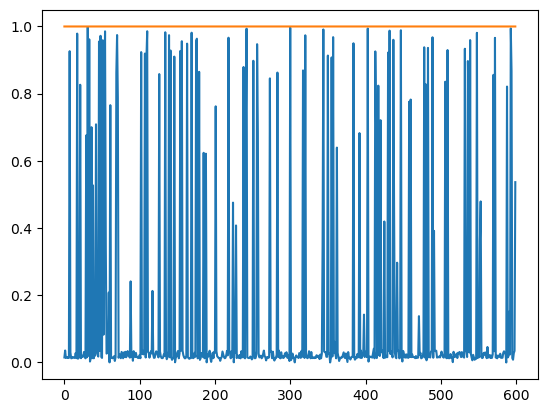

In [65]:
plt.plot(V_y)
plt.plot(salidas_validation)

In [92]:
numero_epocs=50
tolerance = 0.01
epsilons = np.zeros(45)
cont = 0
for L in [1,2,3]:
    for l in [1,2,3,4,5]:
        for eta in [0.2,0.5,0.9]:
            print('------- Modelo {} L {} l {} eta {} --------'.format(cont, L, l, eta))
            neuronas_por_capa = [2] + [l]*L + [1]
            instance = MultilayerPerceptron(neuronas_por_capa,["lineal"]*(len(neuronas_por_capa)-1)+["sigmoid"])
            errores_av, deltas_epochs, epsilon, yd,y= instance.training_data(normalized_data,eta,0.8,0.6,numero_epocs,tolerance)
            epsilons[cont] = epsilon
            plot_energy_avg(errores_av, L, l, eta)
            average_gradients(deltas_epochs,numero_epocs, L, l, eta)
            print('Min errores_av train', np.min(errores_av[0]), 'max', np.max(errores_av[0]), 'mean', np.mean(errores_av[0]))
            print('Min errores_av test', np.min(errores_av[1]), 'max', np.max(errores_av[1]), 'mean', np.mean(errores_av[1]))
            print('\n')
            cont+=1

------- Modelo 0 L 1 l 1 eta 0.2 --------
Min errores_av train 0.3944116184044538 max 0.40388252384976336 mean 0.40322354293526336
Min errores_av test 0.40269287355270583 max 0.406911985437535 mean 0.4064082283969131


------- Modelo 1 L 1 l 1 eta 0.5 --------
Min errores_av train 0.4035178013144391 max 0.40971461079376326 mean 0.4093091450456345
Min errores_av test 0.38948384453331436 max 0.3919883596660773 mean 0.391683505546644


------- Modelo 2 L 1 l 1 eta 0.9 --------
Min errores_av train 0.3981177858123266 max 0.40357068477057206 mean 0.4032336117338726
Min errores_av test 0.40757418210261875 max 0.40970521517232195 mean 0.40944823714062095


------- Modelo 3 L 1 l 2 eta 0.2 --------
Min errores_av train 0.39778835143786273 max 0.4078550213258972 mean 0.40718641051997023
Min errores_av test 0.4030776842043016 max 0.40734231638457746 mean 0.40682617786956315


------- Modelo 4 L 1 l 2 eta 0.5 --------
Min errores_av train 0.39479394119110023 max 0.40017712385069026 mean 0.3997808

(12, 35, 36)

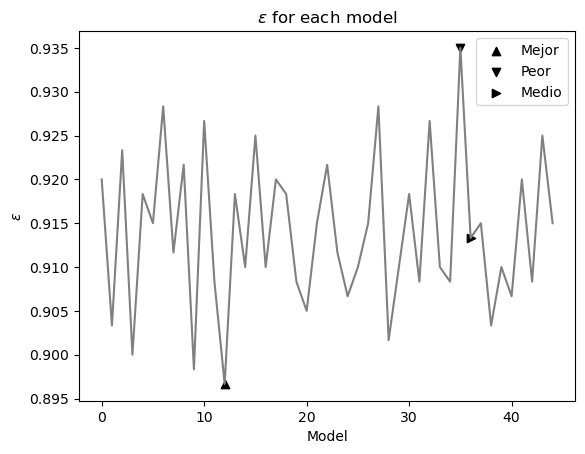

In [105]:
plt.plot(epsilons,color='gray')
plt.scatter(12, epsilons[12], color='black', label='Mejor', marker='^')
plt.scatter(35, epsilons[35], color='black', label='Peor', marker='v')
plt.scatter(36, epsilons[36], color='black', label='Medio', marker='>')
# Agregar leyenda
plt.legend()

# Título y etiquetas de ejes
plt.title('$\epsilon$ for each model')
plt.xlabel('Model')
plt.ylabel('$\epsilon$')
valor_medio = np.mean(epsilons)
np.argmin(epsilons),np.argmax(epsilons), np.argmin(np.abs(epsilons - valor_medio))

Text(0, 0.5, 'Eje Y')

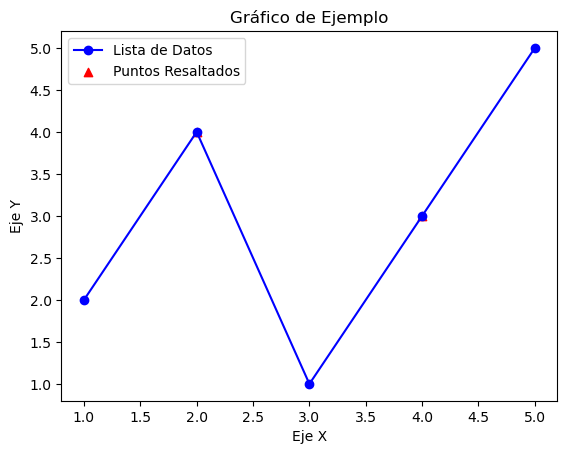

In [99]:
x = [1, 2, 3, 4, 5]
y = [2, 4, 1, 3, 5]

# Trazar la lista
plt.plot(x, y, label='Lista de Datos', marker='o', linestyle='-', color='b')

# Resaltar ciertos puntos
highlight_x = [2, 4]
highlight_y = [4, 3]
plt.scatter(highlight_x, highlight_y, color='r', label='Puntos Resaltados', marker='^')

# Agregar leyenda
plt.legend()

# Título y etiquetas de ejes
plt.title('Gráfico de Ejemplo')
plt.xlabel('Eje X')
plt.ylabel('Eje Y')

In [95]:
np.argmin([1,0,2])

1

In [94]:
epsilons

array([0.92      , 0.90333333, 0.92333333, 0.9       , 0.91833333,
       0.915     , 0.92833333, 0.91166667, 0.92166667, 0.89833333,
       0.92666667, 0.90833333, 0.89666667, 0.91833333, 0.91      ,
       0.925     , 0.91      , 0.92      , 0.91833333, 0.90833333,
       0.905     , 0.915     , 0.92166667, 0.91166667, 0.90666667,
       0.91      , 0.915     , 0.92833333, 0.90166667, 0.91      ,
       0.91833333, 0.90833333, 0.92666667, 0.91      , 0.90833333,
       0.935     , 0.91333333, 0.915     , 0.90333333, 0.91      ,
       0.90666667, 0.92      , 0.90833333, 0.925     , 0.915     ])

Text(0.5, 1.0, 'input features vs output')

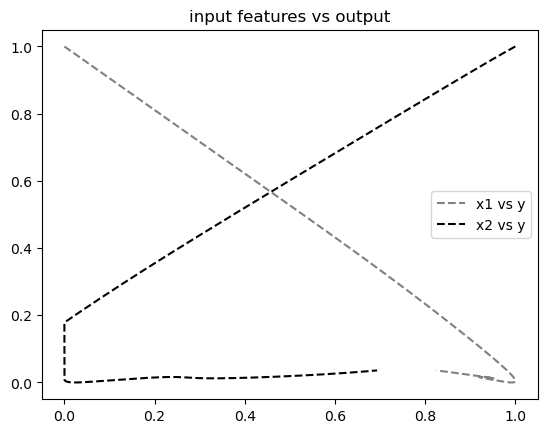

In [5]:
plt.plot(normalized_data[:,0],normalized_data[:,2],'--',color='gray',label='x1 vs y')
plt.plot(normalized_data[:,1],normalized_data[:,2],'--',color='black',label='x2 vs y')
plt.legend()
plt.title('input features vs output')

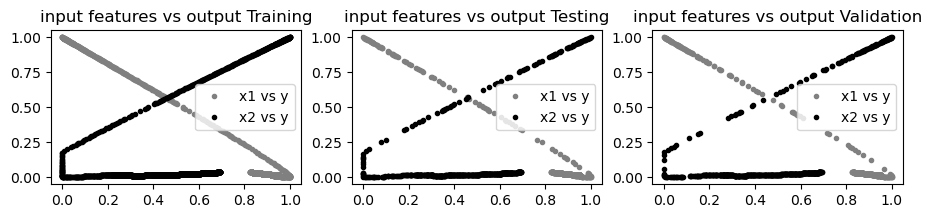

In [20]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(11,2))
S,V,T,t = partitioning(normalized_data,0.8,0.6)
sets = [T,t,V]
sets_titles= ["Training","Testing",'Validation']
for i in range(len(sets)):
    axes[i].plot(sets[i][:,0],sets[i][:,2],'.',color='gray',label='x1 vs y')
    axes[i].plot(sets[i][:,1],sets[i][:,2],'.',color='black',label='x2 vs y')
    axes[i].legend()
    axes[i].set_title('input features vs output ' + sets_titles[i])